In [1]:
library(data.table) 
library(ggplot2)
library(ComplexUpset)
library(repr)
library(grid)
library(pheatmap)

## Upset plot for droplet classification of genetic deconvolution methods

### Define a function to convert the result to a binary matrix 

In [2]:
convert2binary <- function(assignment, identity){
    # table in a long format
    assignment_new <- melt(assignment, id.vars=1)
    assignment_new <- na.omit(assignment_new)
 
    # Subset to identity
    assignment_new <- assignment_new[assignment_new$value==identity,]
    assignment_new <- assignment_new [, -3]

    # table in a wide format
    assignment_new <- dcast(assignment_new, Barcode~variable)
    assignment_new <- as.data.frame(lapply(assignment_new [, -1], as.numeric))

    # turn into a binary matrix
    assignment_new[!is.na(assignment_new)] <- 1
    assignment_new[is.na(assignment_new)] <- 0
    
    return(assignment_new)
}

In [3]:
# Load genetic demultiplexing results
gene_gx38_classi <-fread("../data/pipeline_output/gx38/genetic_classification_all.csv")

# Remove the trial ID
colnames(gene_gx38_classi) <- gsub("_1", "", colnames(gene_gx38_classi))

genetic_gx38_classi_new_singlet <- convert2binary(gene_gx38_classi, 'singlet')
genetic_gx38_classi_new_doublet <- convert2binary(gene_gx38_classi, 'doublet')

Using 'variable' as value column. Use 'value.var' to override

Using 'variable' as value column. Use 'value.var' to override



Warning message:
“The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.
ℹ The deprecated feature was likely used in the ComplexUpset package.
  Please report the issue at
  <https://github.com/krassowski/complex-upset/issues>.”


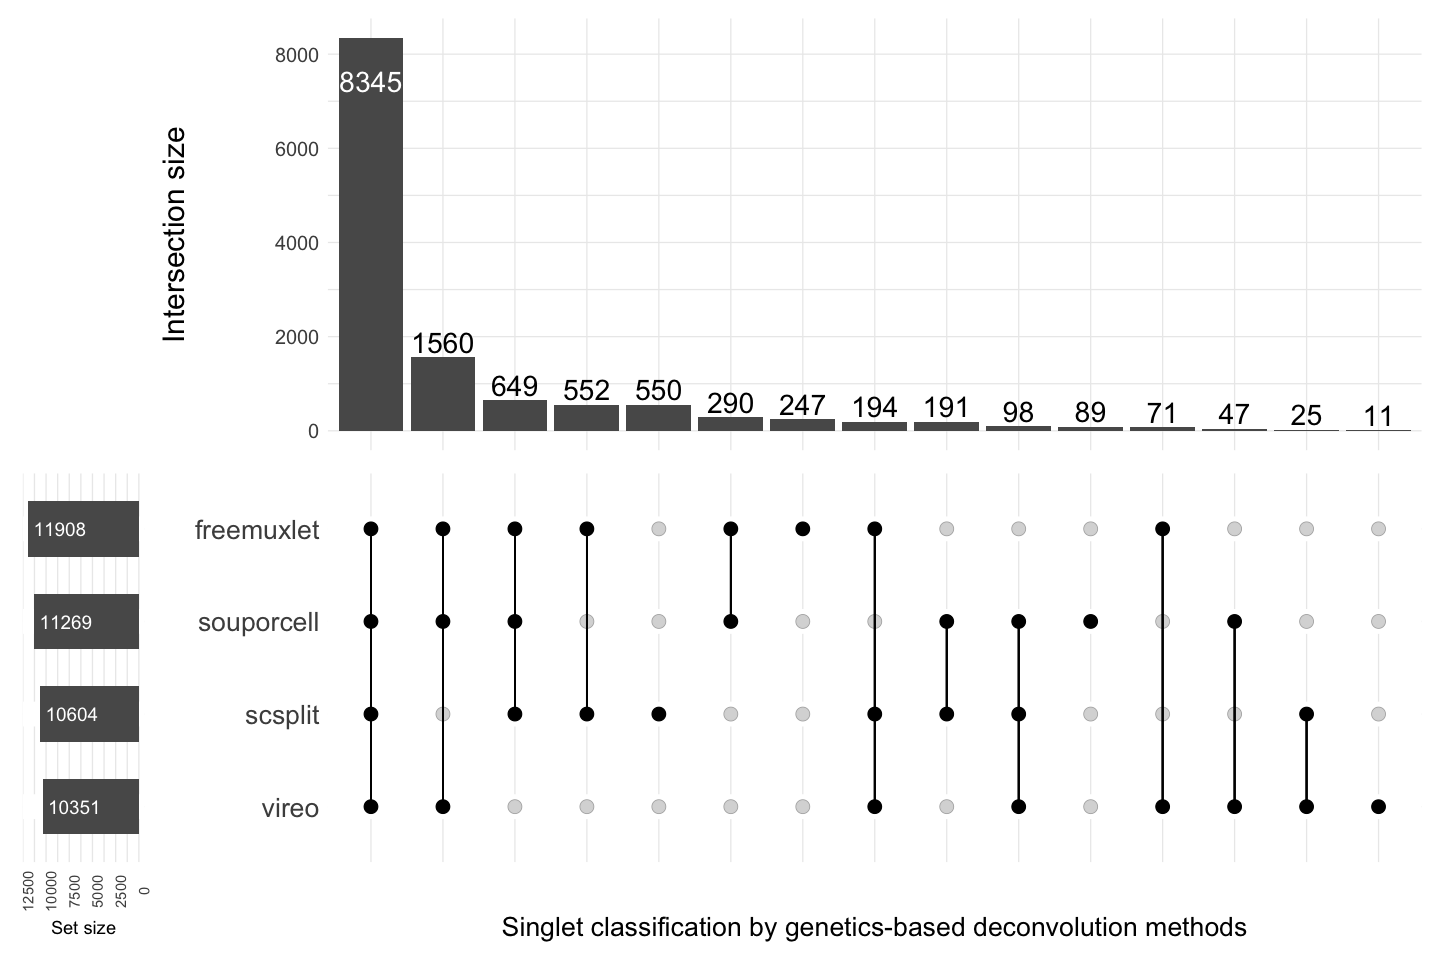

In [4]:
# Change plot size to 12 x 8
options(repr.plot.width=12, repr.plot.height=8)

ComplexUpset::upset(genetic_gx38_classi_new_singlet, colnames(genetic_gx38_classi_new_singlet), width_ratio = 0.1, 
                    height_ratio = 0.9, stripes = 'white', min_degree=1, 
                    name="Singlet classification by genetics-based deconvolution methods",
                    set_sizes=(upset_set_size() + geom_text(aes(label = ..count..), hjust = -0.1, stat = 'count', color = 'white', size=4) +
                               theme(axis.text.x = element_text(angle = 90))),# set size
                    base_annotations=list('Intersection size'= intersection_size(text=list(size=6))+
                                        theme(axis.text=element_text(size=12), axis.title=element_text(size=18))), # intersection size
                    themes=upset_modify_themes(list('intersections_matrix'=theme(axis.text.y=element_text(size=16), #method
                                                                                text=element_text(size=16)))))# title

# ggsave("S14-upset-genetic-singlet-gx38.png", width= 12, height=8, dpi=300)

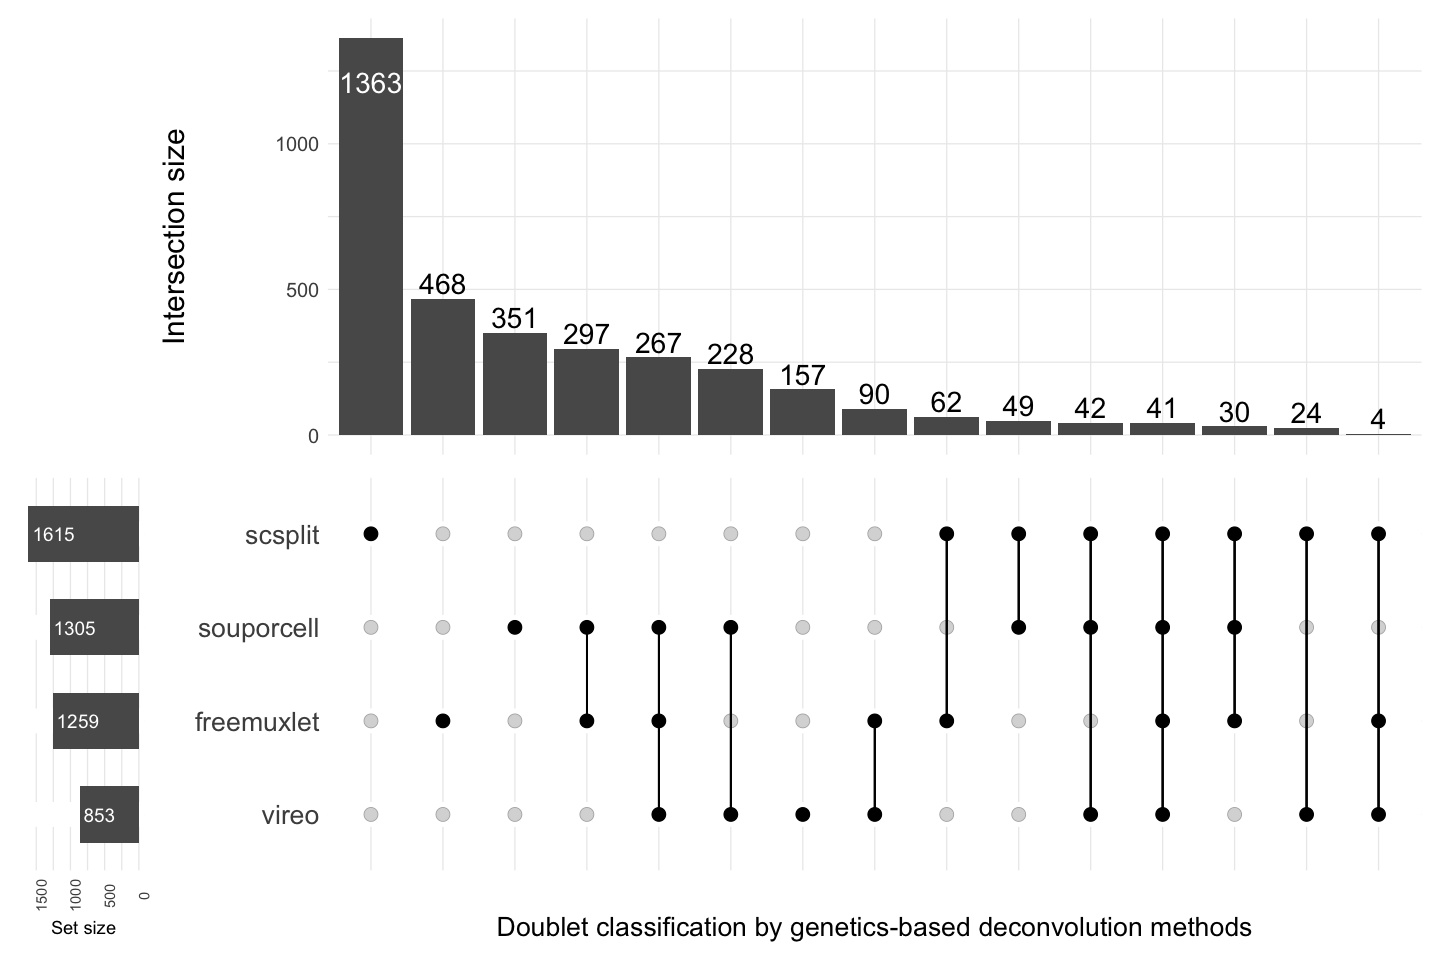

In [5]:
ComplexUpset::upset(genetic_gx38_classi_new_doublet, colnames(genetic_gx38_classi_new_doublet), width_ratio = 0.1, 
                    height_ratio = 0.9, stripes = 'white', min_degree=1, 
                    name="Doublet classification by genetics-based deconvolution methods",
                    set_sizes=(upset_set_size() + geom_text(aes(label = ..count..), hjust = -0.1, stat = 'count', color = 'white', size=4) +
                               theme(axis.text.x = element_text(angle = 90))),# set size
                    base_annotations=list('Intersection size'= intersection_size(text=list(size=6))+
                                        theme(axis.text=element_text(size=12), axis.title=element_text(size=18))), # intersection size
                    themes=upset_modify_themes(list('intersections_matrix'=theme(axis.text.y=element_text(size=16), #method
                                                                                text=element_text(size=16)))))# title

# ggsave("S15-upset-genetic-doublet-gx38.png", width= 12, height=8, dpi=300)

## Visualisation of concordance among genetic deconvolution methods through confusion matrix

In [6]:
# Load genetic demultiplexing results
gene_gx38_assign <-fread("../data/pipeline_output/gx38/genetic_assignment_all.csv")

# Remove the trial ID
colnames(gene_gx38_assign) <- gsub("_1", "", colnames(gene_gx38_assign))

# Remove the donor prefix in vireo column
gene_gx38_assign$vireo <- gsub("donor", "", gene_gx38_assign$vireo)

,0,1,2,3,4,5
,<int>,<int>,<int>,<int>,<int>,<int>
0,0,245,549,0,0,0
1,0,1520,0,0,0,0
2,0,0,0,2476,0,0
3,0,0,0,0,1006,1
4,2064,0,0,0,1,1
5,0,0,0,0,0,2187


pdf 
  3

pdf 
  2

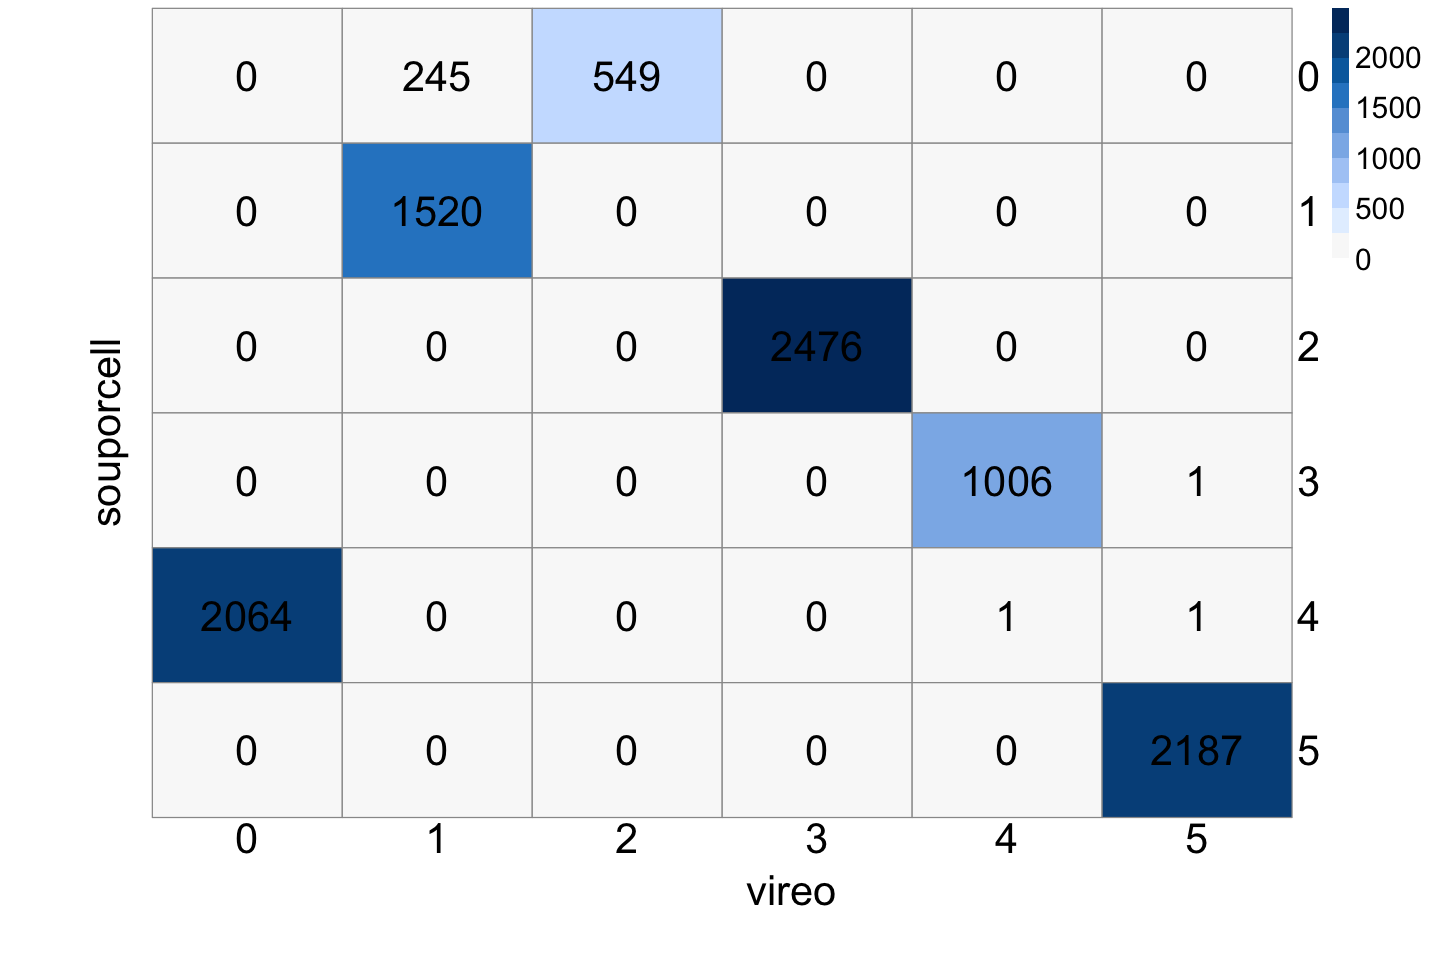

In [7]:
# Create an empyt matrix
confusion_matrix_v_so = as.data.frame(matrix(ncol = 6, nrow = 6))
rownames(confusion_matrix_v_so) = 0:5
colnames(confusion_matrix_v_so) = 0:5

# Fill the matrix
for (i in c(0:5)){
  for (j in c(0:5)){
    row = nrow(gene_gx38_assign[gene_gx38_assign$souporcell == i & gene_gx38_assign$vireo == j,])
    confusion_matrix_v_so[i+1,j+1] = row
  }
}

confusion_matrix_v_so

pdf("S17-heatmap-so-v-gx38.pdf", width=11, height=11)
# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_v_so, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="0",
         number_color = "black", fontsize_number= 25, fontsize = 18, fontsize_row = 25, fontsize_col = 25, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("vireo", y=-0.03, gp=gpar(fontsize=25))
grid.text("souporcell", x=-0.03, rot=90, gp=gpar(fontsize=25))
        
dev.copy()
dev.off()

,0,1,2,3,4,5
,<int>,<int>,<int>,<int>,<int>,<int>
0,0,2,0,2509,0,0
1,1,0,3,0,0,2181
2,2048,2,1,0,0,2
3,0,0,679,0,1,0
4,0,0,0,1,994,0
5,0,1738,5,0,1,2


pdf 
  3

pdf 
  2

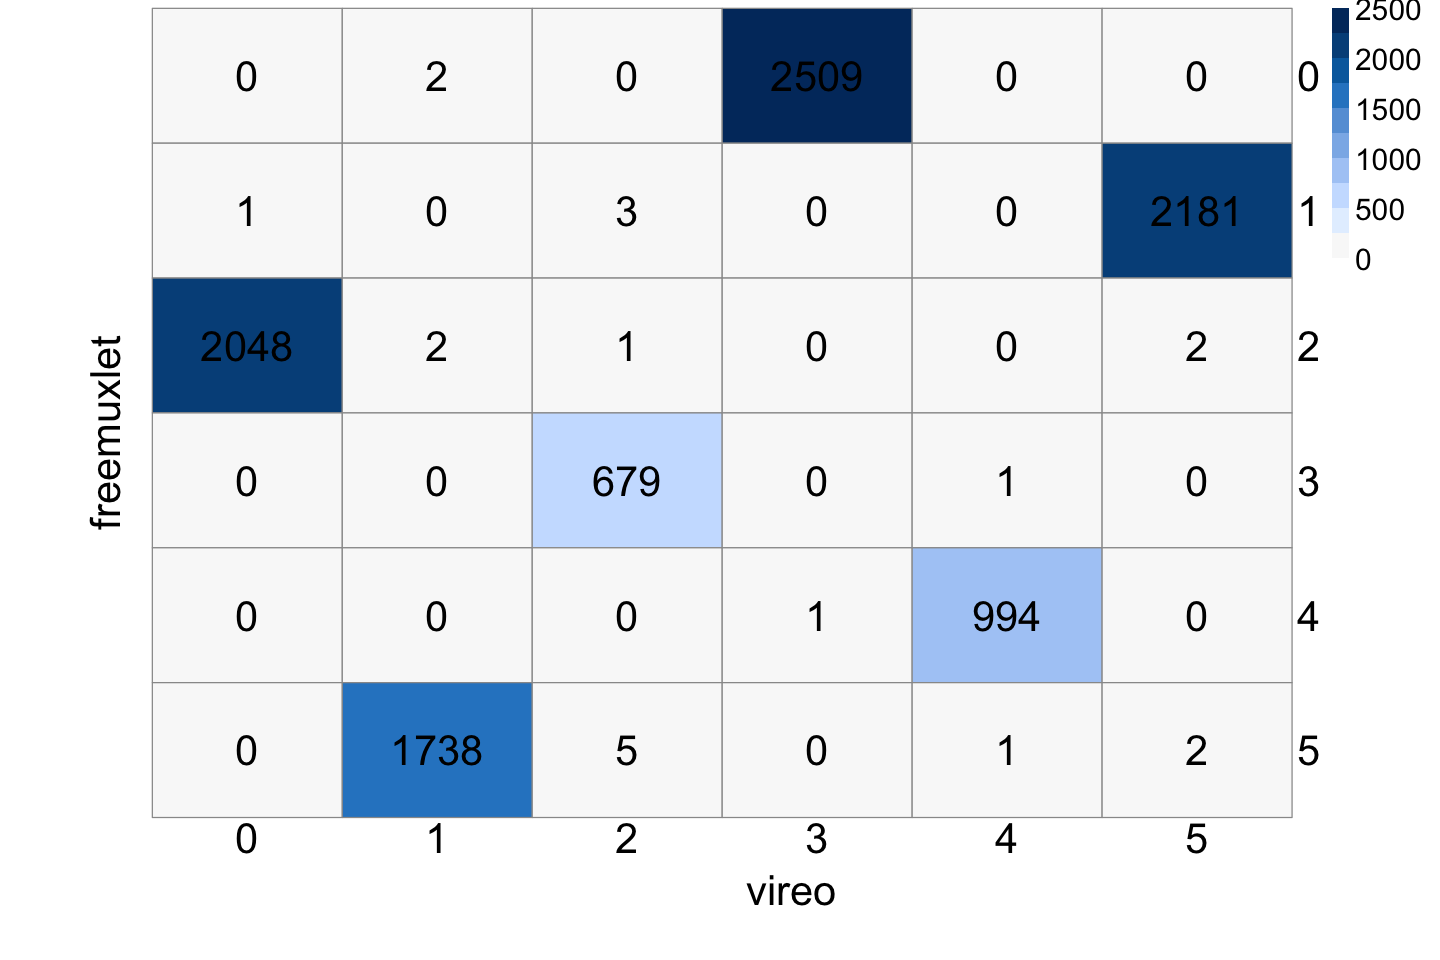

In [8]:
# Create an empyt matrix
confusion_matrix_v_fr = as.data.frame(matrix(ncol = 6, nrow = 6))
rownames(confusion_matrix_v_fr) = 0:5
colnames(confusion_matrix_v_fr) = 0:5

# Fill the matrix
for (i in c(0:5)){
  for (j in c(0:5)){
    row = nrow(gene_gx38_assign[gene_gx38_assign$freemuxlet == i & gene_gx38_assign$vireo == j,])
    confusion_matrix_v_fr[i+1,j+1] = row
  }
}

confusion_matrix_v_fr

pdf("S18-heatmap-fr-v-gx38.pdf", width=11, height=11)

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_v_fr, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="0",
         number_color = "black", fontsize_number= 25, fontsize = 18, fontsize_row = 25, fontsize_col = 25, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("vireo", y=-0.03, gp=gpar(fontsize=25))
grid.text("freemuxlet", x=-0.03, rot=90, gp=gpar(fontsize=25))
        
dev.copy()
dev.off()

,0,1,2,3,4,5
,<int>,<int>,<int>,<int>,<int>,<int>
0,163,166,62,258,61,179
1,222,313,134,17,81,335
2,172,253,97,28,204,508
3,0,0,0,0,0,0
5,776,307,193,12,134,414
6,474,237,84,5,189,399


pdf 
  3

pdf 
  2

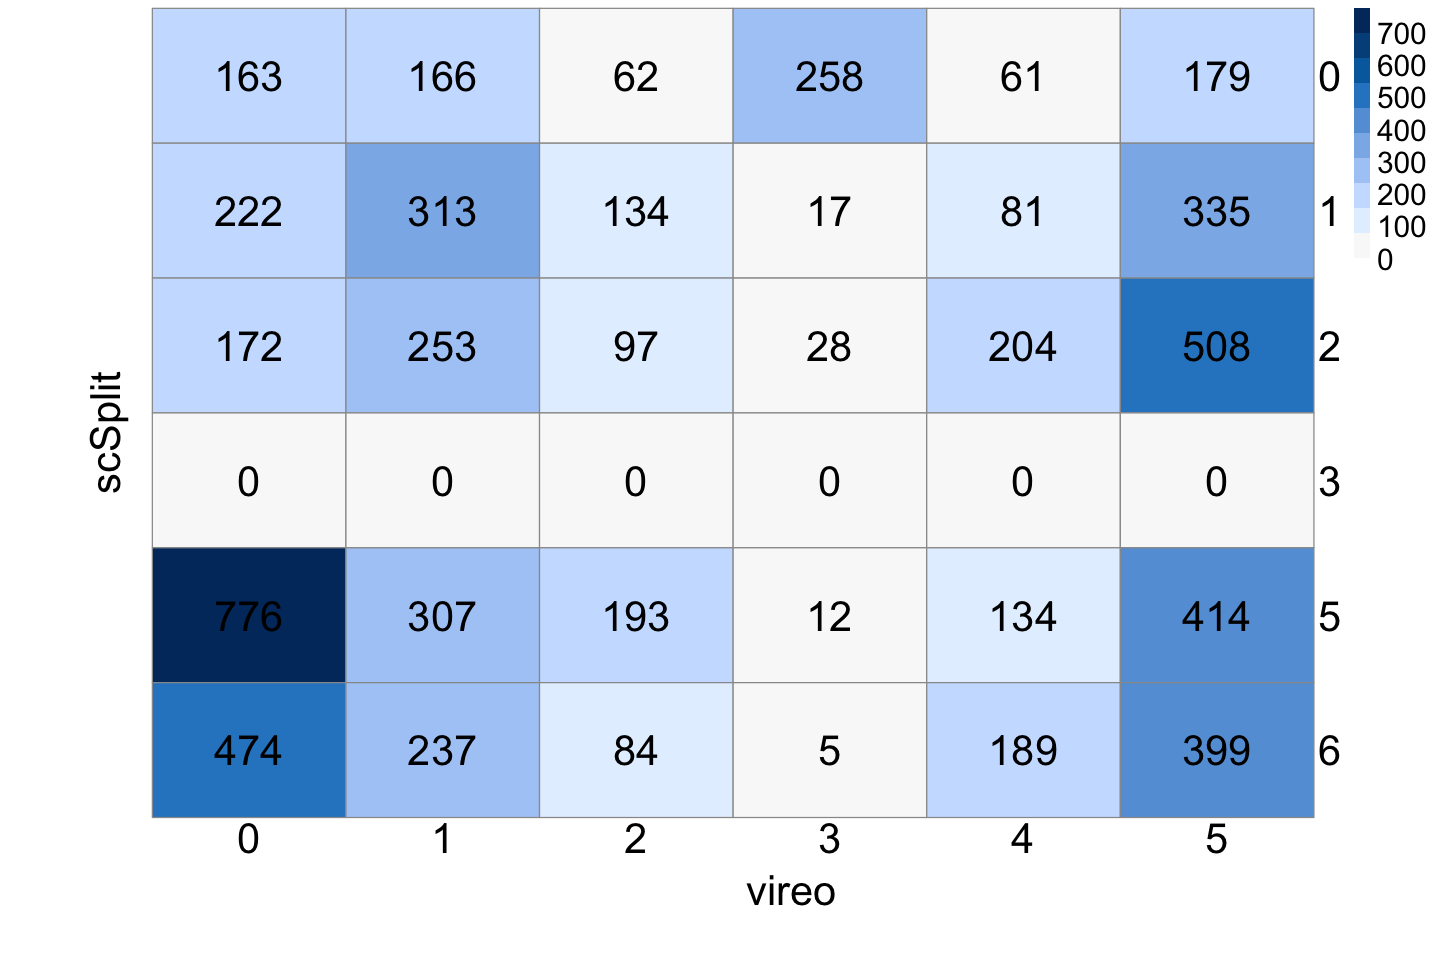

In [9]:
# Create an empyt matrix
confusion_matrix_v_sc = as.data.frame(matrix(ncol = 6, nrow = 6))
colnames(confusion_matrix_v_sc) = 0:5

# scSplit assigned doublets to cluster 4
donor_list <- c(0:3, 5:6)
rownames(confusion_matrix_v_sc) = donor_list

for (i in c(0:5)){
  for (j in c(0:5)){
    row = nrow(gene_gx38_assign[gene_gx38_assign$vireo == j & 
                                gene_gx38_assign$scsplit == donor_list[i+1],])
    confusion_matrix_v_sc[i+1,j+1] = row
  }
}

confusion_matrix_v_sc

pdf("S19-heatmap-v-sc-gx38.pdf", width=11, height=11)

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_v_sc, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="0",
         number_color = "black", fontsize_number= 25, fontsize = 18, fontsize_row = 25, fontsize_col = 25, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("vireo", y=-0.03, gp=gpar(fontsize=25))
grid.text("scSplit", x=-0.03, rot=90, gp=gpar(fontsize=25))
        
dev.copy()
dev.off()
